# LA Crime: 2010 - Present

Wanmo Chen

## Part 1 - Selection

Aspiring actors/actresses, I wanted to examine crime in Los Angeles, in order to decide which neighbourhoods to live in, and which ones to definetely avoid.

The following statistics we include:
* Time
* The neighbourhoods
* Crimes and their victims
* Weapons used, and where they occur
* Demographic analysis

## Part 2 - Wrangling

Let's begin the analysis by downloading the data begin wrangling it.

In [1]:
!wget https://data.lacity.org/api/views/y8tr-7khq/rows.csv

--2017-12-07 01:17:22--  https://data.lacity.org/api/views/y8tr-7khq/rows.csv
Resolving data.lacity.org (data.lacity.org)... 52.206.140.199
Connecting to data.lacity.org (data.lacity.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv’

rows.csv                [  <=>               ] 357.76M  2.51MB/s    in 2m 35s  

Last-modified header invalid -- time-stamp ignored.
2017-12-07 01:19:57 (2.31 MB/s) - ‘rows.csv’ saved [375144413]



In [2]:
!mv rows.csv Crime_Data_from_2010_to_Present.csv

Let's check the amount of records in this data file.

In [4]:
!wc -l Crime*.csv

1621439 Crime_Data_from_2010_to_Present.csv


Let's take look at the first 5 records in the data.

In [5]:
!csvlook Crime*.csv | head -5

|------------+---------------+---------------+---------------+---------+-------------+--------------------+------------+-----------------------------------------------------------------+---------------------------------------------------+------------+------------+----------------+--------------+-----------------------------------------------------------+------------------+------------------------------------------------+-------------+--------------------+--------------+--------------+--------------+--------------+------------------------------------------+------------------------------------+-----------------------|
|  DR Number | Date Reported | Date Occurred | Time Occurred | Area ID | Area Name   | Reporting District | Crime Code | Crime Code Description                                          | MO Codes                                          | Victim Age | Victim Sex | Victim Descent | Premise Code | Premise Description                                       | Weapon Used Code | 

Now that we have briefly analysed the data, let's load the data into a database to continue the wrangling.

In [6]:
%load_ext sql

In [7]:
!dropdb --if-exists -U student project4

NOTICE:  database "project4" does not exist, skipping


In [8]:
!createdb -U student project4

In [9]:
%sql postgresql://student@/project4

'Connected: student@project4'

### Creating Crime Fact Table

In [10]:
%%sql
DROP TABLE IF EXISTS crime_facts;

CREATE TABLE crime_facts (
    DR_number VARCHAR(10),
    date_reported DATE,
    date_occured DATE,
    time_occured INTEGER,
    area_key INTEGER,
    area_name VARCHAR(15),
    report_district VARCHAR(4),
    crime_key INTEGER,
    crime_description VARCHAR(70),
    mo_code VARCHAR(50),
    victim_age INTEGER,
    victim_sex VARCHAR(2),
    victim_descent VARCHAR(5),
    premise_key INTEGER,
    premise_description VARCHAR(60),
    weapon_key INTEGER,
    weapon_description VARCHAR(50),
    status_key VARCHAR(5),
    status_description VARCHAR(15),
    crime_code_1 INTEGER,
    crime_code_2 INTEGER,
    crime_code_3 INTEGER,
    crime_code_4 INTEGER,
    address VARCHAR(50),
    cross_street VARCHAR(50),
    location VARCHAR(30))

Done.
Done.


[]

Importing the crime data into the **Crime Facts Table**

In [11]:
!cp Crime_Data_from_2010_to_Present.csv /tmp/Crime_Data_from_2010_to_Present.csv

In [12]:
%%sql
COPY crime_facts FROM '/tmp/Crime_Data_from_2010_to_Present.csv'
CSV
HEADER;

1621438 rows affected.


[]

Let's verify that the data was successfully uploaded into the table.

In [13]:
%%sql
SELECT COUNT(*)
FROM crime_facts

1 rows affected.


count
1621438


### Resolving the missing values

We are replacing all the null values with a value of 'MISSING' to minimise error.

In [14]:
%%sql
UPDATE crime_facts
SET crime_description = 'MISSING'
WHERE crime_description IS NULL

451 rows affected.


[]

In [15]:
%%sql
UPDATE crime_facts
SET premise_description = 'MISSING'
WHERE premise_description IS NULL

3469 rows affected.


[]

In [16]:
%%sql
UPDATE crime_facts
SET weapon_description = 'MISSING'
WHERE weapon_description IS NULL

1084249 rows affected.


[]

We are also dropping the following columns crime_code_1, crime_code_2, crime_code_3, crime_code_4 since they are empty.

In [17]:
%%sql
ALTER TABLE crime_facts
DROP COLUMN crime_code_1,
DROP COLUMN crime_code_2,
DROP COLUMN crime_code_3,
DROP COLUMN crime_code_4;

Done.


[]

### Create table occured_time

We then create the first dimension table "occured_time" to track all time data.

In [18]:
%%sql
DROP TABLE IF EXISTS occured_time;

CREATE TABLE occured_time(
    occured_time_key SERIAL PRIMARY KEY,
    occured_date DATE,
    occured_time INTEGER,
    occured_hour INTEGER,
    occured_minute INTEGER)

Done.
Done.


[]

Then we insert all the time data into the table, as well as properly calculating time from a 4 digit number (e.g. 0830 = 08:30). We used division and the remainder to represent the accurate hour and minute.

In [19]:
%%sql
INSERT INTO occured_time (occured_date, occured_time, occured_hour, occured_minute)
SELECT DISTINCT date_occured, time_occured, time_occured/100, time_occured-100*(time_occured/100)
FROM crime_facts

474341 rows affected.


[]

Now we want to verify that there is no missing values in date_occured and time_occured.

In [20]:
%%sql
SELECT *
FROM occured_time
LIMIT 5

5 rows affected.


occured_time_key,occured_date,occured_time,occured_hour,occured_minute
1,2010-01-01,1,0,1
2,2010-01-01,2,0,2
3,2010-01-01,5,0,5
4,2010-01-01,7,0,7
5,2010-01-01,10,0,10


We update the crime facts table with the occurred_time_key foreign key from the occurred_time table.

In [23]:
%%sql
ALTER TABLE crime_facts
ADD COLUMN occured_time_key INTEGER,
ADD CONSTRAINT fk_occured_time
    FOREIGN KEY (occured_time_key)
    REFERENCES occured_time;

(psycopg2.ProgrammingError) column "occured_time_key" of relation "crime_facts" already exists
 [SQL: 'ALTER TABLE crime_facts\nADD COLUMN occured_time_key INTEGER,\nADD CONSTRAINT fk_occured_time\n    FOREIGN KEY (occured_time_key)\n    REFERENCES occured_time;']


In [24]:
%%sql
SELECT occured_time_key
FROM crime_facts
LIMIT 5

5 rows affected.


occured_time_key
None
None
None
None
None


In [25]:
%%sql
UPDATE crime_facts
SET occured_time_key = occured_time.occured_time_key
FROM occured_time
WHERE crime_facts.date_occured = occured_time.occured_date
AND crime_facts.time_occured = occured_time.occured_time

1621438 rows affected.


[]

We add the following columns 'day_of_week', 'day_of_week_num', 'year, 'month', and 'day' to further track the time. We also format the day, month, and year in their proper format.

In [26]:
%%sql
ALTER TABLE occured_time
ADD COLUMN day_of_week VARCHAR(10),
ADD COLUMN day_of_week_num INTEGER,
ADD COLUMN year INTEGER,
ADD COLUMN month INTEGER,
ADD COLUMN day INTEGER

Done.


[]

In [27]:
%%sql
UPDATE occured_time
SET day_of_week = TO_CHAR(occured_date, 'Day')

474341 rows affected.


[]

In [28]:
%%sql
UPDATE occured_time
SET day_of_week_num = CAST(TO_CHAR(occured_date, 'D') AS INTEGER)

474341 rows affected.


[]

In [29]:
%%sql
UPDATE occured_time
SET year = CAST(TO_CHAR(occured_date, 'YYYY') AS INTEGER)

474341 rows affected.


[]

In [30]:
%%sql
UPDATE occured_time
SET month = CAST(TO_CHAR(occured_date, 'MM') AS INTEGER)

474341 rows affected.


[]

In [31]:
%%sql
UPDATE occured_time
SET day = CAST(TO_CHAR(occured_date, 'DD') AS INTEGER)

474341 rows affected.


[]

Verifying that the time formatting is correct.

In [26]:
%%sql
SELECT *
FROM occured_time
LIMIT 5

5 rows affected.


occured_time_key,occured_date,occured_time,occured_hour,occured_minute,day_of_week,day_of_week_num,year,month,day
1,2012-07-30,355,3,55,Monday,2,2012,7,30
2,2014-11-11,2355,23,55,Tuesday,3,2014,11,11
3,2012-02-01,1620,16,20,Wednesday,4,2012,2,1
4,2014-09-08,1400,14,0,Monday,2,2014,9,8
5,2012-07-19,1130,11,30,Thursday,5,2012,7,19


### Create area table

We create the area dimension table that records information about the neighbourhoods.

In [32]:
%%sql
DROP TABLE IF EXISTS area;

CREATE TABLE area(
    area_key SERIAL PRIMARY KEY,
    area_name VARCHAR(15),
    premise_description VARCHAR(60))

Done.
Done.


[]

Inserting the neighbourhood data into the table.

In [33]:
%%sql
INSERT INTO area (area_name, premise_description)
SELECT DISTINCT area_name, premise_description
FROM crime_facts

3436 rows affected.


[]

Now we verify that the data was input successfully.

In [34]:
%%sql
SELECT *
FROM area
LIMIT 5

5 rows affected.


area_key,area_name,premise_description
1,Harbor,HOSPITAL
2,West Valley,FOSTER HOME BOYS OR GIRLS*
3,Hollywood,NAIL SALON
4,Southeast,AUTO SUPPLY STORE*
5,Wilshire,FINANCE COMPANY


Adding the area key to the crime facts table.

In [35]:
%%sql
UPDATE crime_facts
SET area_key = area.area_key
FROM area
WHERE crime_facts.area_name = area.area_name
AND crime_facts.premise_description = area.premise_description

1621438 rows affected.


[]

In [36]:
%%sql
ALTER TABLE crime_facts
ADD CONSTRAINT fk_area
    FOREIGN KEY (area_key)
    REFERENCES area;

Done.


[]

### Create crime table

Creating a table that consists of all the crime data.

In [37]:
%%sql
DROP TABLE IF EXISTS crime;

CREATE TABLE crime(
    crime_key SERIAL PRIMARY KEY,
    crime_description VARCHAR(70),
    crime_weapon VARCHAR(50))

Done.
Done.


[]

Inserting all of the crime data into the table and verify the input was successful.

In [38]:
%%sql
INSERT INTO crime (crime_description, crime_weapon)
SELECT DISTINCT crime_description, weapon_description
FROM crime_facts

2197 rows affected.


[]

In [39]:
%%sql
SELECT *
FROM crime
LIMIT 5

5 rows affected.


crime_key,crime_description,crime_weapon
1,BATTERY - SIMPLE ASSAULT,UNKNOWN WEAPON/OTHER WEAPON
2,CRIMINAL HOMICIDE,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
3,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD0036",FOLDING KNIFE
4,ATTEMPTED ROBBERY,KNIFE WITH BLADE OVER 6 INCHES IN LENGTH
5,CRIMINAL HOMICIDE,ROCK/THROWN OBJECT


Adding crime_key to the crime facts table.

In [40]:
%%sql
UPDATE crime_facts
SET crime_key = crime.crime_key
FROM crime
WHERE crime_facts.crime_description = crime.crime_description
AND crime_facts.weapon_description = crime.crime_weapon

1621438 rows affected.


[]

In [41]:
%%sql
ALTER TABLE crime_facts
ADD CONSTRAINT fk_crime
    FOREIGN KEY (crime_key)
    REFERENCES crime;

Done.


[]

Verifying the crime input.

In [42]:
%%sql
SELECT *
FROM crime
LIMIT 5

5 rows affected.


crime_key,crime_description,crime_weapon
1,BATTERY - SIMPLE ASSAULT,UNKNOWN WEAPON/OTHER WEAPON
2,CRIMINAL HOMICIDE,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)"
3,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD0036",FOLDING KNIFE
4,ATTEMPTED ROBBERY,KNIFE WITH BLADE OVER 6 INCHES IN LENGTH
5,CRIMINAL HOMICIDE,ROCK/THROWN OBJECT


### Create victim table

Creating a victim dimension table containing all of the victim table.

In [43]:
%%sql
DROP TABLE IF EXISTS victim;

CREATE TABLE victim(
    victim_key SERIAL PRIMARY KEY,
    victim_age INTEGER,
    victim_sex VARCHAR(2),
    victim_descent VARCHAR(5))

Done.
Done.


[]

In [44]:
%%sql
INSERT INTO victim (victim_age, victim_sex, victim_descent)
SELECT DISTINCT victim_age, victim_sex, victim_descent
FROM crime_facts

2350 rows affected.


[]

Verifying that all of the victim data was input correctly.

In [45]:
%%sql
SELECT *
FROM victim
LIMIT 5

5 rows affected.


victim_key,victim_age,victim_sex,victim_descent
1,None,None,None
2,68,F,A
3,14,M,K
4,15,M,I
5,54,F,I


Adding victim_key to the crime facts table.

In [46]:
%%sql
ALTER TABLE crime_facts
ADD COLUMN victim_key INTEGER,
ADD CONSTRAINT fk_victim
    FOREIGN KEY (victim_key)
    REFERENCES victim;

Done.


[]

In [ ]:
%%sql
UPDATE crime_facts
SET victim_key = victim.victim_key
FROM victim
WHERE (crime_facts.victim_age = victim.victim_age OR (crime_facts.victim_age IS NULL AND victim.victim_age IS NULL))
AND (crime_facts.victim_sex = victim.victim_sex OR (crime_facts.victim_sex IS NULL AND victim.victim_sex IS NULL))
AND (crime_facts.victim_descent = victim.victim_descent OR (crime_facts.victim_descent IS NULL AND victim.victim_descent IS NULL))

Adding a new column 'age_range' to put ages into buckets of 10.

In [ ]:
%%sql
ALTER TABLE victim
ADD age_range VARCHAR(10)

In [44]:
%%sql
UPDATE victim
SET age_range = '10-19'
WHERE victim_age<20

262 rows affected.


[]

In [45]:
%%sql
UPDATE victim
SET age_range = '20-29'
WHERE victim_age<30
AND victim_age>=20

338 rows affected.


[]

In [46]:
%%sql
UPDATE victim
SET age_range = '30-39'
WHERE victim_age<40
AND victim_age>=30

319 rows affected.


[]

In [47]:
%%sql
UPDATE victim
SET age_range = '40-49'
WHERE victim_age<50
AND victim_age>=40

311 rows affected.


[]

In [48]:
%%sql
UPDATE victim
SET age_range = '50-59'
WHERE victim_age<60
AND victim_age>=50

304 rows affected.


[]

In [49]:
%%sql
UPDATE victim
SET age_range = '60-69'
WHERE victim_age<70
AND victim_age>=60

255 rows affected.


[]

In [50]:
%%sql
UPDATE victim
SET age_range = '70-79'
WHERE victim_age<80
AND victim_age>=70

204 rows affected.


[]

In [51]:
%%sql
UPDATE victim
SET age_range = 'Over 80'
WHERE victim_age>80

291 rows affected.


[]

Verifying the buckets were input.

In [52]:
%%sql
SELECT *
FROM victim
ORDER BY victim_key
LIMIT 5

5 rows affected.


victim_key,victim_age,victim_sex,victim_descent,age_range
1,10,F,A,10-19
2,10,F,B,10-19
3,10,F,F,10-19
4,10,F,H,10-19
5,10,F,K,10-19


### Create status table

Creating a table containing crime status information.

In [53]:
%%sql
DROP TABLE IF EXISTS status;

CREATE TABLE status(
    status_key SERIAL PRIMARY KEY,
    status_description VARCHAR(50))

Done.
Done.


[]

Inputting status information into the table.

In [ ]:
%%sql
INSERT INTO status (status_description)
SELECT DISTINCT status_description
FROM crime_facts

Adding new key column 'status_key'.

In [55]:
%%sql
ALTER TABLE crime_facts
DROP COLUMN status_key,
ADD COLUMN status_key INTEGER

Done.


[]

Verifying status input.

In [56]:
%%sql
SELECT *
FROM status

6 rows affected.


status_key,status_description
1,Invest Cont
2,Juv Other
3,UNK
4,Juv Arrest
5,Adult Arrest
6,Adult Other


In [57]:
%%sql
UPDATE crime_facts
SET status_key = status.status_key
FROM status
WHERE crime_facts.status_description = status.status_description

1621438 rows affected.


[]

### Drop columns in fact table

In [58]:
%%sql
SELECT *
FROM crime_facts
LIMIT 5

5 rows affected.


dr_number,date_reported,date_occured,time_occured,area_key,area_name,report_district,crime_key,crime_description,mo_code,victim_age,victim_sex,victim_descent,premise_key,premise_description,weapon_key,weapon_description,status_description,address,cross_street,location,occured_time_key,victim_key,status_key
130100507,2013-01-02,2013-01-02,1420,295,Central,0174,298,BATTERY - SIMPLE ASSAULT,0416 0400 0429,23,M,H,102,SIDEWALK,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,800 S SPRING ST,None,"(34.0431, -118.2536)",42647,380,1
130100508,2013-01-02,2013-01-02,1430,305,Central,0134,1178,INTIMATE PARTNER - SIMPLE ASSAULT,2004 1218 1813 1814 2002 0444 2000,39,F,H,101,STREET,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,4TH,HILL,"(34.0503, -118.2504)",152508,892,1
130100509,2013-01-02,2013-01-02,1500,268,Central,0185,298,BATTERY - SIMPLE ASSAULT,0917 0419 0429 0417,18,F,H,406,OTHER STORE,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Juv Arrest,300 E PICO BL,None,"(34.0352, -118.2583)",73010,210,4
130100518,2013-01-05,2013-01-05,100,256,Central,0171,1178,INTIMATE PARTNER - SIMPLE ASSAULT,2000 0416,34,F,H,735,NIGHT CLUB (OPEN EVENINGS ONLY),400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Invest Cont,800 W OLYMPIC BL,None,"(34.045, -118.264)",201976,727,1
130100521,2013-01-05,2013-01-05,1600,295,Central,0156,1178,INTIMATE PARTNER - SIMPLE ASSAULT,0305 0400 0429 2000,50,F,B,102,SIDEWALK,400,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,6TH ST,SAN JULIAN ST,"(34.0423, -118.2452)",41927,1232,6


In [59]:
%%sql
ALTER TABLE crime_facts
DROP COLUMN dr_number,
DROP COLUMN date_reported,
DROP COLUMN date_occured,
DROP COLUMN time_occured,
DROP COLUMN area_name,
DROP COLUMN report_district,
DROP COLUMN crime_description,
DROP COLUMN mo_code,
DROP COLUMN victim_age,
DROP COLUMN victim_sex,
DROP COLUMN victim_descent,
DROP COLUMN premise_key,
DROP COLUMN premise_description,
DROP COLUMN weapon_key,
DROP COLUMN weapon_description,
DROP COLUMN status_description,
DROP COLUMN address,
DROP COLUMN cross_street,
DROP COLUMN location;

Done.


[]

In [60]:
%%sql
SELECT *
FROM crime_facts
LIMIT 5

5 rows affected.


area_key,crime_key,occured_time_key,victim_key,status_key
295,298,42647,380,1
305,1178,152508,892,1
268,298,73010,210,4
256,1178,201976,727,1
295,1178,41927,1232,6


# Part 3 - Analysis

### Occured time analysis

Here we are looking at the number of crimes per years, and can be seen in the below bar graph. You can see that there is at least 200,000 crimes per year.

In [64]:
%%sql
SELECT year, COUNT(*)
FROM crime_facts
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
GROUP BY year
ORDER BY year

8 rows affected.


year,count
2010,208600
2011,200200
2012,200826
2013,191814
2014,194527
2015,214037
2016,223309
2017,188125


<Container object of 8 artists>

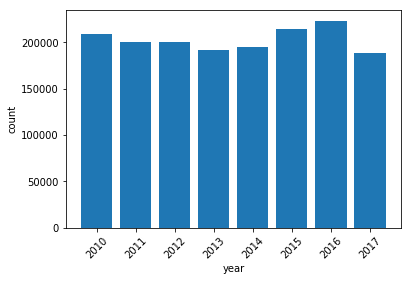

In [65]:
%matplotlib inline
_.bar()

We then look at the number of crimes that occur each month in total.

In [66]:
%%sql
SELECT month, COUNT(*)
FROM crime_facts
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
GROUP BY month
ORDER BY month

12 rows affected.


month,count
1,142691
2,123558
3,138397
4,135254
5,141214
6,138880
7,143444
8,143700
9,137851
10,142036


<Container object of 12 artists>

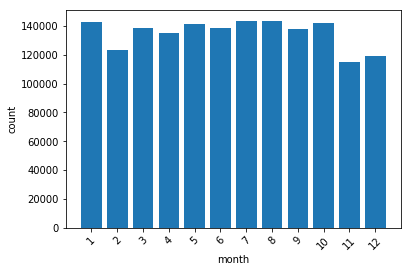

In [67]:
_.bar()

Looking at the total number of crimes that occur on different days of the week.

In [68]:
%%sql
SELECT day_of_week, COUNT(*)
FROM crime_facts
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
GROUP BY day_of_week_num, day_of_week
ORDER BY day_of_week_num

7 rows affected.


day_of_week,count
Sunday,222240
Monday,231016
Tuesday,227154
Wednesday,229454
Thursday,228069
Friday,250234
Saturday,233271


<Container object of 7 artists>

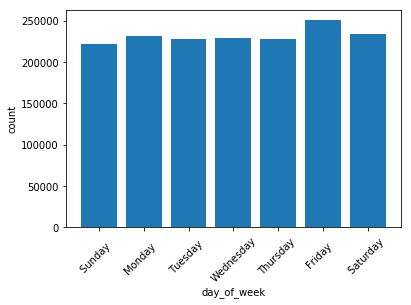

In [69]:
_.bar()

What we found interesting is we found the day of each year where the most crimes occur, which ended up being New Year's of each each year.

In [70]:
%%sql
SELECT a.occured_date, a.year, a.count
FROM (SELECT COUNT(*) AS count, occured_date, year
    FROM crime_facts
    JOIN occured_time
    ON crime_facts.occured_time_key = occured_time.occured_time_key
    GROUP BY occured_date, year) AS a
JOIN (SELECT t.year, MAX(count) AS max_count
    FROM (SELECT COUNT(*) AS count, occured_date, year
        FROM crime_facts
        JOIN occured_time
        ON crime_facts.occured_time_key = occured_time.occured_time_key
        GROUP BY occured_date, year) AS t
     GROUP BY t.year) AS b
ON a.year = b.year
AND a.count = b.max_count
ORDER BY year

8 rows affected.


occured_date,year,count
2010-01-01,2010,2143
2011-01-01,2011,2055
2012-01-01,2012,1647
2013-01-01,2013,1467
2014-01-01,2014,1333
2015-01-01,2015,1271
2016-01-01,2016,1145
2017-01-01,2017,913


<Container object of 8 artists>

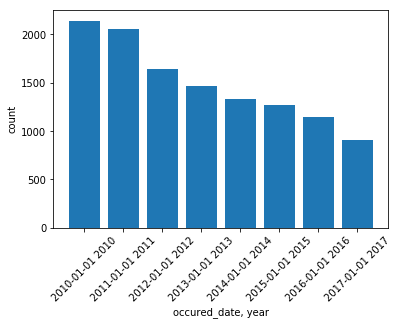

In [71]:
_.bar()

We then found out the time that most crimes occur.

In [72]:
%%sql
SELECT occured_hour, COUNT(*)
FROM crime_facts
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
GROUP BY occured_hour
ORDER BY occured_hour

24 rows affected.


occured_hour,count
0,66882
1,46453
2,39224
3,28759
4,21611
5,19619
6,27540
7,41032
8,69114
9,61007


<Container object of 24 artists>

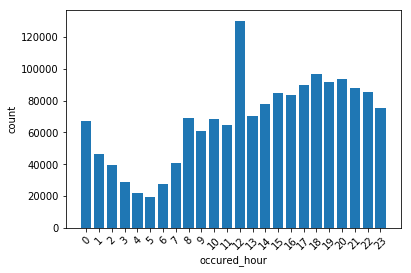

In [73]:
_.bar()

### Area Analysis

Now we want to analyse the crime that occurs in different neighbourhoods in LA.

In [76]:
%%sql
SELECT area_name, COUNT(*)
FROM crime_facts
JOIN area
ON crime_facts.area_key = area.area_key
GROUP BY area_name
ORDER BY count DESC

21 rows affected.


area_name,count
77th Street,113061
Southwest,104611
N Hollywood,88374
Pacific,85692
Southeast,85452
Mission,81974
Northeast,78254
Van Nuys,77346
Newton,76283
Devonshire,75656


We also created a pie chart to show the percentage of crimes in each neighbourhood.

(-1.1016454048449051,
 1.1010994058779995,
 -1.1010106060424247,
 1.1000481240972584)

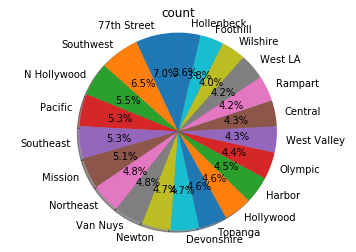

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
_.pie(autopct='%1.1f%%',
        shadow=True,startangle=90) 
plt.axis('equal')

Here, we looked at where different crimes occur in these neighbourhoods.

In [79]:
%%sql
SELECT premise_description, COUNT(*) AS count
FROM crime_facts
JOIN area
ON crime_facts.area_key = area.area_key
GROUP BY premise_description
ORDER BY count DESC
LIMIT 10

10 rows affected.


premise_description,count
STREET,360799
SINGLE FAMILY DWELLING,335019
"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",209211
PARKING LOT,115302
SIDEWALK,81153
OTHER BUSINESS,72619
"VEHICLE, PASSENGER/TRUCK",61888
DRIVEWAY,33197
GARAGE/CARPORT,29017
DEPARTMENT STORE,22779


### Crime analysis

We took a look at the different crime statistics starting with which type of crimes occurred in LA. We found that Battery - Simple Assault was the most common crime where they were almost 150,000 incidents.

In [80]:
%%sql
SELECT crime_description, COUNT(*)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
GROUP BY crime_description
ORDER BY count DESC
LIMIT 10

10 rows affected.


crime_description,count
BATTERY - SIMPLE ASSAULT,148950
BURGLARY FROM VEHICLE,124315
VEHICLE - STOLEN,124238
BURGLARY,117223
THEFT PLAIN - PETTY ($950 & UNDER),116109
THEFT OF IDENTITY,102559
INTIMATE PARTNER - SIMPLE ASSAULT,87821
"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114",81523
VANDALISM - MISDEAMEANOR ($399 OR UNDER),72862
"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",69395


We then looked at the weapons the criminals use during their crimes.

In [82]:
%%sql
SELECT crime_weapon, COUNT(*)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
WHERE crime_weapon != 'MISSING'
GROUP BY crime_weapon
ORDER BY count DESC
LIMIT 10

10 rows affected.


crime_weapon,count
"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",327235
VERBAL THREAT,44761
UNKNOWN WEAPON/OTHER WEAPON,41917
HAND GUN,25897
SEMI-AUTOMATIC PISTOL,10266
KNIFE WITH BLADE 6INCHES OR LESS,9587
OTHER KNIFE,7112
UNKNOWN FIREARM,6151
VEHICLE,5475
REVOLVER,4627


We also looked at the type of premises that crimes occurred in each neighbourhood.

In [83]:
%%sql
SELECT a.area_name, a.premise_description, count
FROM(SELECT area_name, premise_description, COUNT(*)
    FROM crime_facts
    JOIN area
    ON crime_facts.area_key = area.area_key
    GROUP BY area_name, premise_description) AS a
JOIN(SELECT b.area_name, MAX(count) AS max_count
    FROM(SELECT area_name, premise_description, COUNT(*)
        FROM crime_facts
        JOIN area
        ON crime_facts.area_key = area.area_key
        GROUP BY area_name, premise_description) AS b
    GROUP BY b.area_name) AS c
ON a.area_name  =c.area_name
AND a.count = c.max_count
ORDER BY count DESC

21 rows affected.


area_name,premise_description,count
77th Street,SINGLE FAMILY DWELLING,32430
Southwest,STREET,24875
Southeast,SINGLE FAMILY DWELLING,24538
Newton,STREET,24239
Devonshire,SINGLE FAMILY DWELLING,22760
West Valley,SINGLE FAMILY DWELLING,20568
Northeast,STREET,20452
Mission,SINGLE FAMILY DWELLING,20289
Topanga,SINGLE FAMILY DWELLING,19314
Hollenbeck,STREET,18981


### Victim analysis

Here we look at who are the victims of these crimes. The following victim_sex denotes as M as male, F as female, X as Unknown, H as Unknown.

#### Victim sex

In [65]:
%%sql
SELECT victim_sex, COUNT(*)
FROM crime_facts
JOIN victim
ON crime_facts.victim_key = victim.victim_key
WHERE victim_sex IS NOT NULL
AND victim_sex !='-'
GROUP BY victim_sex
ORDER BY COUNT(*) DESC

4 rows affected.


victim_sex,count
M,756300
F,690610
X,25625
H,54


The following pie chart dictates that crimes happened to almost an equal percentage of males and females.

(-1.1052343941820006,
 1.1033208585152967,
 -1.108254007972977,
 1.1003930479987674)

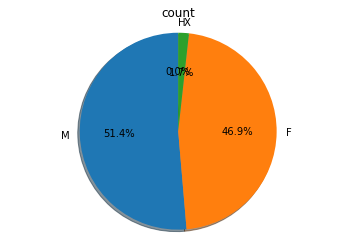

In [66]:
%matplotlib inline
import matplotlib.pyplot as plt
_.pie(autopct='%1.1f%%',
        shadow=True,startangle=90) 
plt.axis('equal')

#### Victim age

We looked at the different ages of the victims. The different amount of ages created an illegible bar graph so we placed them in buckets and created another bar graph.

In [75]:
%%sql
SELECT victim_age, COUNT(*)
FROM crime_facts
JOIN victim
ON crime_facts.victim_key = victim.victim_key
WHERE victim_age IS NOT NULL
GROUP BY victim_age
ORDER BY victim_age

90 rows affected.


victim_age,count
10,24911
11,25900
12,25818
13,27973
14,32991
15,38449
16,37000
17,13085
18,17540
19,23034


<Container object of 90 artists>

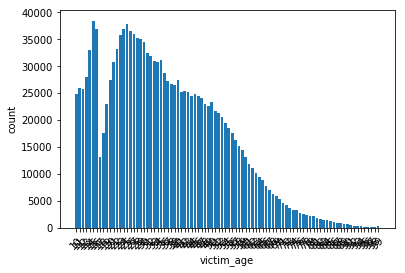

In [76]:
_.bar()

In [69]:
%%sql
SELECT age_range, COUNT(*)
FROM crime_facts
JOIN victim
ON crime_facts.victim_key = victim.victim_key
WHERE age_range IS NOT NULL
GROUP BY age_range
ORDER BY age_range

8 rows affected.


age_range,count
10-19,266701
20-29,344805
30-39,300778
40-49,246785
50-59,188721
60-69,91584
70-79,34484
Over 80,14226


Here we can see the biggest victims are between the ages of 20-29.

<Container object of 8 artists>

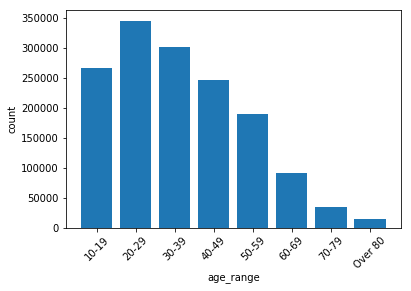

In [70]:
_.bar()

We looked at the neighbourhoods where victims were under the age of 18.

In [71]:
%%sql
SELECT area_name, COUNT(*)
FROM crime_facts
Join area
ON crime_facts.area_key = area.area_key
JOIN victim
ON crime_facts.victim_key = victim.victim_key
WHERE victim_age<18
GROUP BY area_name
ORDER BY COUNT(*) DESC
LIMIT 5

5 rows affected.


area_name,count
77th Street,19689
N Hollywood,15796
Newton,15067
Harbor,14833
Southeast,14799


<Container object of 5 artists>

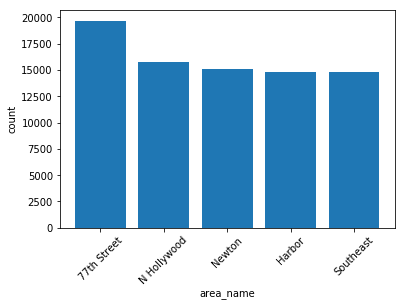

In [72]:
_.bar()

Find out what's the most frequent kind of crime occured on each age group.

In [74]:
%%sql
SELECT a.crime_description, a.age_range, a.count
FROM (SELECT COUNT(*) AS count, crime_description, age_range
    FROM crime_facts
    JOIN crime
    ON crime_facts.crime_key = crime.crime_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    GROUP BY crime_description, age_range) AS a
JOIN (SELECT t.age_range, MAX(count) AS max_count
    FROM (SELECT COUNT(*) AS count, crime_description, age_range
        FROM crime_facts
        JOIN crime
        ON crime_facts.crime_key = crime.crime_key
        JOIN victim
        ON crime_facts.victim_key = victim.victim_key
        GROUP BY crime_description, age_range) AS t
     GROUP BY t.age_range) AS b
ON a.age_range = b.age_range
AND a.count = b.max_count
ORDER BY age_range

8 rows affected.


crime_description,age_range,count
VEHICLE - STOLEN,10-19,107455
BATTERY - SIMPLE ASSAULT,20-29,40587
BURGLARY FROM VEHICLE,30-39,33307
BATTERY - SIMPLE ASSAULT,40-49,25317
BATTERY - SIMPLE ASSAULT,50-59,20422
BURGLARY,60-69,11931
BURGLARY,70-79,5380
BURGLARY,Over 80,2812


#### Victim descent

Here we wanted to look at the difference in victim descent. The following descents are denoted as:
* H - Hispanic
* W - White
* B - Black
* O - Other
* X - Unknown

In [73]:
%%sql
SELECT victim_descent, COUNT(*)
FROM crime_facts
JOIN victim
ON crime_facts.victim_key = victim.victim_key
WHERE victim_descent IS NOT NULL
GROUP BY victim_descent
ORDER BY COUNT(*) DESC
LIMIT 5

5 rows affected.


victim_descent,count
H,562195
W,400222
B,260574
O,156489
X,43590


### Dangerous neighborhood for female and male

Here we are looking at the distinct neighbourhoods that are the most dangerous for males and females.

In [77]:
%%sql
SELECT a.area_name, a.female_count, b.count, (100*female_count/count) AS female_percentage
FROM(SELECT area.area_name, COUNT(*) AS female_count
    FROM crime_facts
    JOIN area
    ON crime_facts.area_key = area.area_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    WHERE victim.victim_sex = 'F'
    GROUP BY area_name) AS a
JOIN(SELECT area.area_name, COUNT(*)
    FROM crime_facts
    JOIN area
    ON crime_facts.area_key = area.area_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    GROUP BY area_name) AS b
ON a.area_name = b.area_name
ORDER by female_percentage DESC
LIMIT 5

5 rows affected.


area_name,female_count,count,female_percentage
Southeast,44394,85452,51
77th Street,56462,113061,49
Southwest,49990,104611,47
Rampart,29249,68525,42
West LA,28946,67829,42


Southeast is the most dangerous neighbourhood for females. Yikes!

<Container object of 5 artists>

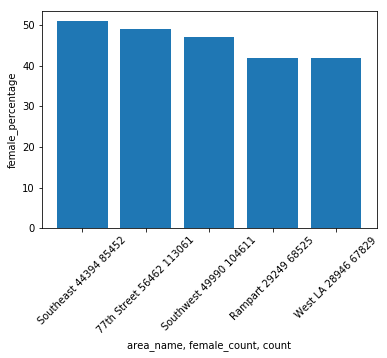

In [78]:
_.bar()

In [79]:
%%sql
SELECT a.area_name, a.male_count, b.count, (100*male_count/count) AS male_percentage
FROM(SELECT area.area_name, COUNT(*) AS male_count
    FROM crime_facts
    JOIN area
    ON crime_facts.area_key = area.area_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    WHERE victim.victim_sex = 'M'
    GROUP BY area_name) AS a
JOIN(SELECT area.area_name, COUNT(*)
    FROM crime_facts
    JOIN area
    ON crime_facts.area_key = area.area_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    GROUP BY area_name) AS b
ON a.area_name = b.area_name
ORDER by male_percentage DESC
LIMIT 5

5 rows affected.


area_name,male_count,count,male_percentage
Central,39567,69031,57
Hollywood,39212,74131,52
Topanga,38710,75092,51
N Hollywood,45129,88374,51
West Valley,35079,69313,50


The most dangerous neighbourhood for guys is the Central neighbourhood.

<Container object of 5 artists>

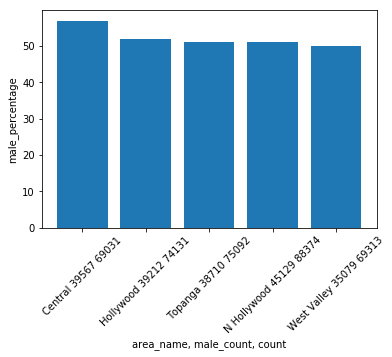

In [80]:
%matplotlib inline
_.bar()

### Crime frequently occured on female and male

We decided to look at the crimes that occur the most against males and females.

* The most common crime to occur against females is rape and purse snatching.
* The most common crime to occur against males is assault with a deadly weapon.

In [91]:
%%sql
SELECT a.crime_description, a.female_count, b.count, (100*female_count/count) AS female_percentage
FROM(SELECT crime.crime_description, COUNT(*) AS female_count
    FROM crime_facts
    JOIN crime
    ON crime_facts.crime_key = crime.crime_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    WHERE victim.victim_sex = 'F'
    GROUP BY crime_description) AS a
JOIN(SELECT crime.crime_description, COUNT(*)
    FROM crime_facts
    JOIN crime
    ON crime_facts.crime_key = crime.crime_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    GROUP BY crime_description) AS b
ON a.crime_description = b.crime_description
WHERE count > 800
ORDER by female_percentage DESC
LIMIT 10

10 rows affected.


crime_description,female_count,count,female_percentage
"RAPE, FORCIBLE",7448,7512,99
"RAPE, ATTEMPTED",884,895,98
PURSE SNATCHING,925,982,94
BATTERY WITH SEXUAL CONTACT,7576,8249,91
SEXUAL PENTRATION WITH A FOREIGN OBJECT,1491,1641,90
PEEPING TOM,821,908,90
"SEX, UNLAWFUL",3193,3517,90
STALKING,1288,1510,85
CHILD ANNOYING (17YRS & UNDER),3530,4249,83
INDECENT EXPOSURE,2159,2650,81


In [94]:
%%sql
SELECT a.crime_description, a.male_count, b.count, (100*male_count/count) AS male_percentage
FROM(SELECT crime.crime_description, COUNT(*) AS male_count
    FROM crime_facts
    JOIN crime
    ON crime_facts.crime_key = crime.crime_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    WHERE victim.victim_sex = 'M'
    GROUP BY crime_description) AS a
JOIN(SELECT crime.crime_description, COUNT(*)
    FROM crime_facts
    JOIN crime
    ON crime_facts.crime_key = crime.crime_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    GROUP BY crime_description) AS b
ON a.crime_description = b.crime_description
WHERE count > 800
ORDER by male_percentage DESC
LIMIT 10

10 rows affected.


crime_description,male_count,count,male_percentage
ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER,1112,1281,86
CRIMINAL HOMICIDE,1904,2205,86
RESISTING ARREST,2278,2653,85
BATTERY POLICE (SIMPLE),2842,3531,80
DISCHARGE FIREARMS/SHOTS FIRED,2150,2884,74
SHOPLIFTING - PETTY THEFT ($950 & UNDER),26318,35910,73
"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",50312,69395,72
BIKE - STOLEN,6414,9013,71
"DEFRAUDING INNKEEPER/THEFT OF SERVICES, $400 & UNDER",1250,1738,71
ATTEMPTED ROBBERY,6519,9217,70


### Crime frequently occured on youngs and olds

We looked at the crimes that occured to minors and seniors. Here we looked at anyone under the age of 20 were minors, and above 60, seniors.

Minors stole cars, and committed unlawful sexual activities.

In [95]:
%%sql
SELECT a.crime_description, a.young_count, b.count, (100*young_count/count) AS young_percentage
FROM(SELECT crime.crime_description, COUNT(*) AS young_count
    FROM crime_facts
    JOIN crime
    ON crime_facts.crime_key = crime.crime_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    WHERE victim.victim_age <= 20
    GROUP BY crime_description) AS a
JOIN(SELECT crime.crime_description, COUNT(*)
    FROM crime_facts
    JOIN crime
    ON crime_facts.crime_key = crime.crime_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    GROUP BY crime_description) AS b
ON a.crime_description = b.crime_description
WHERE count > 800
ORDER by young_percentage DESC
LIMIT 10

10 rows affected.


crime_description,young_count,count,young_percentage
"SEX, UNLAWFUL",3406,3517,96
VEHICLE - STOLEN,107458,124238,86
CHILD ANNOYING (17YRS & UNDER),3605,4249,84
CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)0060,3548,6560,54
CHILD ABUSE (PHYSICAL) - SIMPLE ASSAULT,3637,6981,52
ORAL COPULATION,527,1289,40
CHILD ABUSE (PHYSICAL) - AGGRAVATED ASSAULT,533,1315,40
BATTERY WITH SEXUAL CONTACT,3069,8249,37
"RAPE, FORCIBLE",2570,7512,34
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),21891,65721,33


Seniors stole and committed identity theft - go figure.

In [96]:
%%sql
SELECT a.crime_description, a.old_count, b.count, (100*old_count/count) AS old_percentage
FROM(SELECT crime.crime_description, COUNT(*) AS old_count
    FROM crime_facts
    JOIN crime
    ON crime_facts.crime_key = crime.crime_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    WHERE victim.victim_age >= 60
    GROUP BY crime_description) AS a
JOIN(SELECT crime.crime_description, COUNT(*)
    FROM crime_facts
    JOIN crime
    ON crime_facts.crime_key = crime.crime_key
    JOIN victim
    ON crime_facts.victim_key = victim.victim_key
    GROUP BY crime_description) AS b
ON a.crime_description = b.crime_description
WHERE count > 800
ORDER by old_percentage DESC
LIMIT 10

10 rows affected.


crime_description,old_count,count,old_percentage
"BUNCO, GRAND THEFT",1439,5318,27
"BURGLARY, ATTEMPTED",1953,10136,19
DOCUMENT FORGERY / STOLEN FELONY,3702,19174,19
THEFT OF IDENTITY,19453,102559,18
PURSE SNATCHING,182,982,18
BURGLARY,20512,117223,17
SHOTS FIRED AT INHABITED DWELLING,318,2051,15
"BUNCO, PETTY THEFT",528,3302,15
DISTURBING THE PEACE,398,2828,14
THEFT FROM MOTOR VEHICLE - ATTEMPT,124,951,13


### Analysis on time pattern - focus on the top 3 crime

We wanted to look at the number of crimes committed each year for the top three crimes:

* BATTERY - SIMPLE ASSAULT
* BURGLARY FROM VEHICLE
* VEHICLE - STOLEN

#### Year analysis

In [81]:
%%sql
SELECT crime_description, year, COUNT(crime_description)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
WHERE crime_description = 'BATTERY - SIMPLE ASSAULT'
GROUP BY year, crime_description
ORDER BY year 

8 rows affected.


crime_description,year,count
BATTERY - SIMPLE ASSAULT,2010,20519
BATTERY - SIMPLE ASSAULT,2011,19902
BATTERY - SIMPLE ASSAULT,2012,19815
BATTERY - SIMPLE ASSAULT,2013,18924
BATTERY - SIMPLE ASSAULT,2014,18403
BATTERY - SIMPLE ASSAULT,2015,17583
BATTERY - SIMPLE ASSAULT,2016,17915
BATTERY - SIMPLE ASSAULT,2017,15889


<Container object of 8 artists>

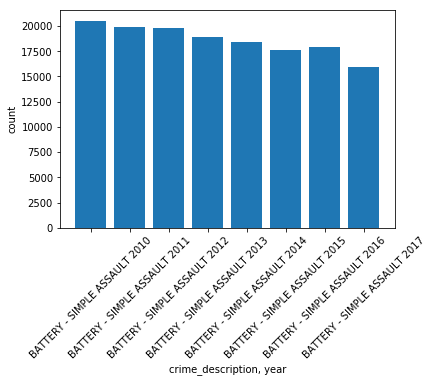

In [82]:
%matplotlib inline
_.bar()

In [97]:
%%sql
SELECT crime_description, year, COUNT(crime_description)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
WHERE crime_description = 'BURGLARY FROM VEHICLE'
GROUP BY year, crime_description
ORDER BY year 

8 rows affected.


crime_description,year,count
BURGLARY FROM VEHICLE,2010,17684
BURGLARY FROM VEHICLE,2011,15883
BURGLARY FROM VEHICLE,2012,15911
BURGLARY FROM VEHICLE,2013,15500
BURGLARY FROM VEHICLE,2014,13074
BURGLARY FROM VEHICLE,2015,14464
BURGLARY FROM VEHICLE,2016,16750
BURGLARY FROM VEHICLE,2017,15049


<Container object of 8 artists>

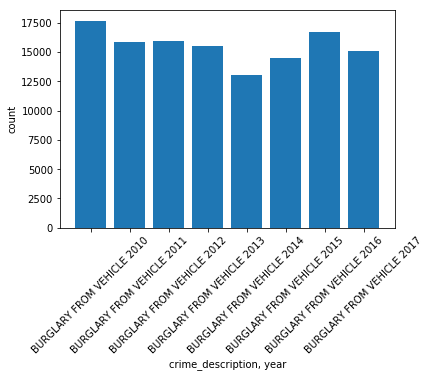

In [98]:
%matplotlib inline
_.bar()

In [99]:
%%sql
SELECT crime_description, year, COUNT(crime_description)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
WHERE crime_description = 'VEHICLE - STOLEN'
GROUP BY year, crime_description
ORDER BY year 

8 rows affected.


crime_description,year,count
VEHICLE - STOLEN,2010,16656
VEHICLE - STOLEN,2011,15164
VEHICLE - STOLEN,2012,14821
VEHICLE - STOLEN,2013,13938
VEHICLE - STOLEN,2014,13693
VEHICLE - STOLEN,2015,16049
VEHICLE - STOLEN,2016,18299
VEHICLE - STOLEN,2017,15618


<Container object of 8 artists>

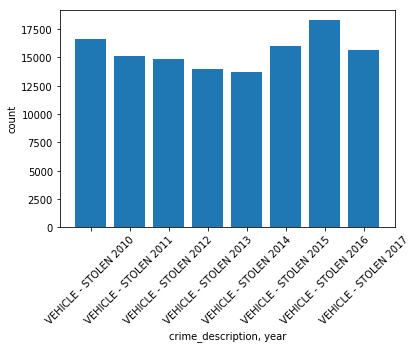

In [100]:
_.bar()

#### Month analysis

We continued to do this analysis with these crimes each month.

In [83]:
%%sql
SELECT crime_description, month, COUNT(crime_description)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
WHERE crime_description = 'BATTERY - SIMPLE ASSAULT'
GROUP BY month, crime_description
ORDER BY month 

12 rows affected.


crime_description,month,count
BATTERY - SIMPLE ASSAULT,1,11678
BATTERY - SIMPLE ASSAULT,2,10988
BATTERY - SIMPLE ASSAULT,3,12829
BATTERY - SIMPLE ASSAULT,4,12626
BATTERY - SIMPLE ASSAULT,5,13697
BATTERY - SIMPLE ASSAULT,6,13069
BATTERY - SIMPLE ASSAULT,7,13509
BATTERY - SIMPLE ASSAULT,8,13546
BATTERY - SIMPLE ASSAULT,9,13221
BATTERY - SIMPLE ASSAULT,10,13526


<Container object of 12 artists>

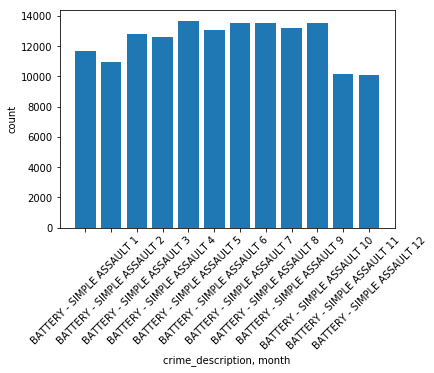

In [84]:
%matplotlib inline
_.bar()

In [101]:
%%sql
SELECT crime_description, month, COUNT(crime_description)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
WHERE crime_description = 'BURGLARY FROM VEHICLE'
GROUP BY month, crime_description
ORDER BY month 

12 rows affected.


crime_description,month,count
BURGLARY FROM VEHICLE,1,11621
BURGLARY FROM VEHICLE,2,10116
BURGLARY FROM VEHICLE,3,10631
BURGLARY FROM VEHICLE,4,10535
BURGLARY FROM VEHICLE,5,10636
BURGLARY FROM VEHICLE,6,10197
BURGLARY FROM VEHICLE,7,10587
BURGLARY FROM VEHICLE,8,10313
BURGLARY FROM VEHICLE,9,10049
BURGLARY FROM VEHICLE,10,10701


<Container object of 12 artists>

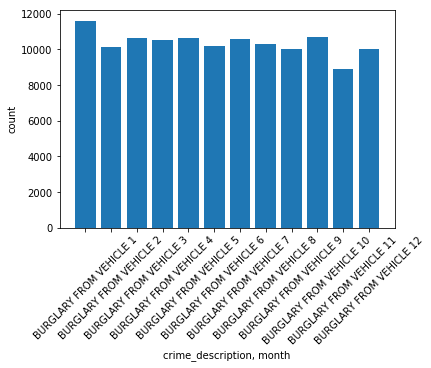

In [102]:
_.bar()

In [103]:
%%sql
SELECT crime_description, month, COUNT(crime_description)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
WHERE crime_description = 'VEHICLE - STOLEN'
GROUP BY month, crime_description
ORDER BY month 

12 rows affected.


crime_description,month,count
VEHICLE - STOLEN,1,11214
VEHICLE - STOLEN,2,9506
VEHICLE - STOLEN,3,10225
VEHICLE - STOLEN,4,9962
VEHICLE - STOLEN,5,10441
VEHICLE - STOLEN,6,10366
VEHICLE - STOLEN,7,10699
VEHICLE - STOLEN,8,10790
VEHICLE - STOLEN,9,10283
VEHICLE - STOLEN,10,11367


<Container object of 12 artists>

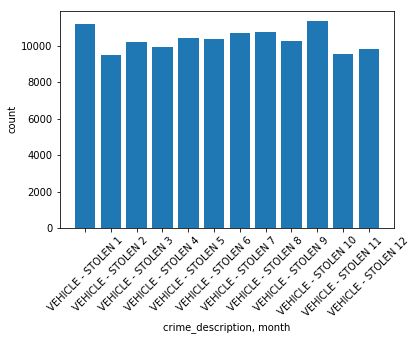

In [104]:
_.bar()

#### Weekday analysis

Following months, we did the same crime analysis for each day of the week.

In [85]:
%%sql
SELECT crime_description, day_of_week, COUNT(crime_description)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
WHERE crime_description = 'BATTERY - SIMPLE ASSAULT'
GROUP BY day_of_week_num, day_of_week, crime_description
ORDER BY day_of_week_num

7 rows affected.


crime_description,day_of_week,count
BATTERY - SIMPLE ASSAULT,Sunday,23914
BATTERY - SIMPLE ASSAULT,Monday,20421
BATTERY - SIMPLE ASSAULT,Tuesday,19969
BATTERY - SIMPLE ASSAULT,Wednesday,20364
BATTERY - SIMPLE ASSAULT,Thursday,19967
BATTERY - SIMPLE ASSAULT,Friday,21498
BATTERY - SIMPLE ASSAULT,Saturday,22817


<Container object of 7 artists>

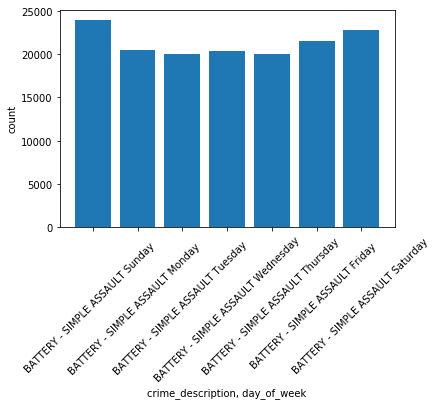

In [86]:
%matplotlib inline
_.bar()

In [105]:
%%sql
SELECT crime_description, day_of_week, COUNT(crime_description)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
WHERE crime_description = 'BURGLARY FROM VEHICLE'
GROUP BY day_of_week_num, day_of_week, crime_description
ORDER BY day_of_week_num

7 rows affected.


crime_description,day_of_week,count
BURGLARY FROM VEHICLE,Sunday,17691
BURGLARY FROM VEHICLE,Monday,17039
BURGLARY FROM VEHICLE,Tuesday,17489
BURGLARY FROM VEHICLE,Wednesday,17629
BURGLARY FROM VEHICLE,Thursday,17421
BURGLARY FROM VEHICLE,Friday,18436
BURGLARY FROM VEHICLE,Saturday,18610


<Container object of 7 artists>

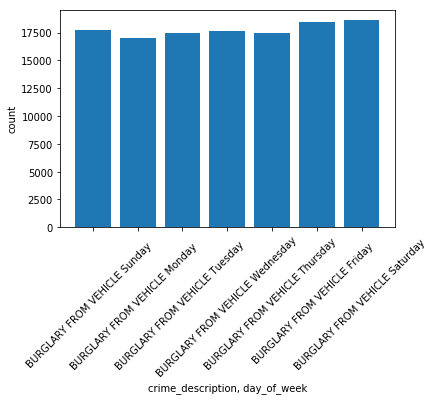

In [106]:
_.bar()

In [107]:
%%sql
SELECT crime_description, day_of_week, COUNT(crime_description)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
WHERE crime_description = 'VEHICLE - STOLEN'
GROUP BY day_of_week_num, day_of_week, crime_description
ORDER BY day_of_week_num

7 rows affected.


crime_description,day_of_week,count
VEHICLE - STOLEN,Sunday,17392
VEHICLE - STOLEN,Monday,17227
VEHICLE - STOLEN,Tuesday,17124
VEHICLE - STOLEN,Wednesday,17536
VEHICLE - STOLEN,Thursday,17364
VEHICLE - STOLEN,Friday,18934
VEHICLE - STOLEN,Saturday,18661


<Container object of 7 artists>

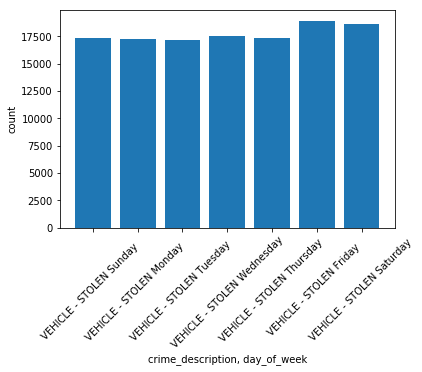

In [108]:
_.bar()

#### Hour analysis

We even took it down to the hour - most crimes occurred in the evening.

In [87]:
%%sql
SELECT crime_description, occured_hour, COUNT(crime_description)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
WHERE crime_description = 'BATTERY - SIMPLE ASSAULT'
GROUP BY occured_hour, crime_description
ORDER BY occured_hour

24 rows affected.


crime_description,occured_hour,count
BATTERY - SIMPLE ASSAULT,0,5290
BATTERY - SIMPLE ASSAULT,1,5760
BATTERY - SIMPLE ASSAULT,2,5023
BATTERY - SIMPLE ASSAULT,3,2679
BATTERY - SIMPLE ASSAULT,4,1657
BATTERY - SIMPLE ASSAULT,5,1346
BATTERY - SIMPLE ASSAULT,6,1792
BATTERY - SIMPLE ASSAULT,7,3328
BATTERY - SIMPLE ASSAULT,8,4782
BATTERY - SIMPLE ASSAULT,9,5229


<Container object of 24 artists>

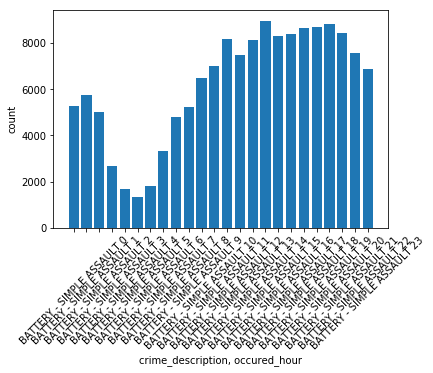

In [88]:
%matplotlib inline
_.bar()

In [109]:
%%sql
SELECT crime_description, occured_hour, COUNT(crime_description)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
WHERE crime_description = 'BURGLARY FROM VEHICLE'
GROUP BY occured_hour, crime_description
ORDER BY occured_hour

24 rows affected.


crime_description,occured_hour,count
BURGLARY FROM VEHICLE,0,5118
BURGLARY FROM VEHICLE,1,3963
BURGLARY FROM VEHICLE,2,3109
BURGLARY FROM VEHICLE,3,2275
BURGLARY FROM VEHICLE,4,1581
BURGLARY FROM VEHICLE,5,1512
BURGLARY FROM VEHICLE,6,1813
BURGLARY FROM VEHICLE,7,2376
BURGLARY FROM VEHICLE,8,3212
BURGLARY FROM VEHICLE,9,3124


<Container object of 24 artists>

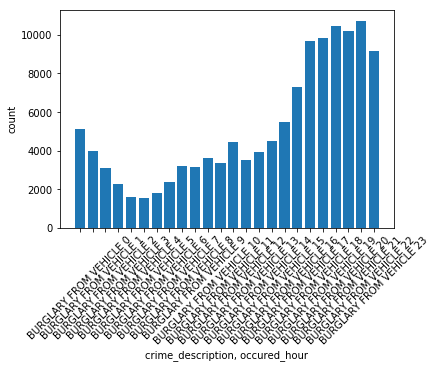

In [110]:
_.bar()

In [111]:
%%sql
SELECT crime_description, occured_hour, COUNT(crime_description)
FROM crime_facts
JOIN crime
ON crime_facts.crime_key = crime.crime_key
JOIN occured_time
ON crime_facts.occured_time_key = occured_time.occured_time_key
WHERE crime_description = 'VEHICLE - STOLEN'
GROUP BY occured_hour, crime_description
ORDER BY occured_hour

24 rows affected.


crime_description,occured_hour,count
VEHICLE - STOLEN,0,4255
VEHICLE - STOLEN,1,3559
VEHICLE - STOLEN,2,2722
VEHICLE - STOLEN,3,1961
VEHICLE - STOLEN,4,1618
VEHICLE - STOLEN,5,1856
VEHICLE - STOLEN,6,2689
VEHICLE - STOLEN,7,3235
VEHICLE - STOLEN,8,3958
VEHICLE - STOLEN,9,3154


<Container object of 24 artists>

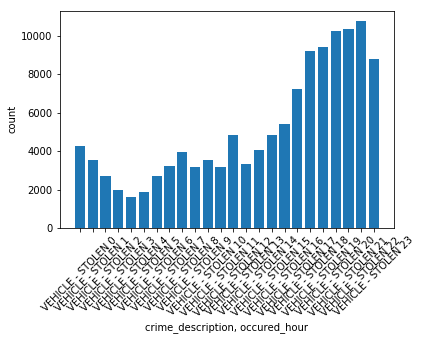

In [112]:
_.bar()

# Part 3 - Augmentation
## Comparison of LA Crime to Chicago Crime


I decided to compare our analysis of LA crime to Chicago Crime to see if there were any similarities between the two cities.

First  download the data and begin to analyse it.

In [1]:
!wget https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv

--2017-12-06 01:31:13--  https://data.cityofchicago.org/api/views/ijzp-q8t2/rows.csv
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.140.199
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.140.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘rows.csv.1’

rows.csv.1              [       <=>          ]   1.42G  2.07MB/s    in 12m 1s  

Last-modified header invalid -- time-stamp ignored.
2017-12-06 01:43:13 (2.02 MB/s) - ‘rows.csv.1’ saved [1526979194]



Renaming the csv file to chicago.csv for easier use.

In [2]:
!mv rows.csv.1 chicago.csv

Take a look of at the ID, Date, Primary Type, Location, and Year Columns.

In [3]:
!csvcut -c1,3,6,8,18 chicago.csv | csvlook | head -5

|-----------+------------------------+-----------------------------------+-------------------------------------------------+-------|
|  ID       | Date                   | Primary Type                      | Location Description                            | Year  |
|-----------+------------------------+-----------------------------------+-------------------------------------------------+-------|
|  4647369  | 01/31/2006 12:13:05 PM | NARCOTICS                         | SCHOOL, PUBLIC, BUILDING                        | 2006  |
|  4647370  | 03/21/2006 07:00:00 PM | CRIMINAL TRESPASS                 | PARKING LOT/GARAGE(NON.RESID.)                  | 2006  |


We then took these columns and placed them into a new csv file called chicago2.csv

In [11]:
!csvcut -c1,3,6,8,18 chicago.csv > chicago2.csv

## Wrangling and Table Creation

Now we go ahead and build a new database with the chicago information to begin our comparison.

In [1]:
%load_ext sql

In [2]:
%sql postgresql://student@/project4

'Connected: student@project4'

### chicago_crime Fact Table Creation

In [3]:
%%sql
DROP TABLE IF EXISTS chicago_crime;

CREATE TABLE chicago_crime(
    id INTEGER,
    date TIMESTAMP,
    type VARCHAR(500),
    location VARCHAR(500),
    year INTEGER)


Done.
Done.


[]

Inserting the data into our newly made chicago_crime table.

In [4]:
!cp chicago2.csv /tmp/chicago.csv

In [5]:
%%sql
COPY chicago_crime FROM '/tmp/chicago.csv'
CSV
HEADER;

6488956 rows affected.


[]

Verifying that input into the table was successful.

In [6]:
%%sql
SELECT*
FROM chicago_crime
LIMIT 10

10 rows affected.


id,date,type,location,year
4647369,2006-01-31 12:13:05,NARCOTICS,"SCHOOL, PUBLIC, BUILDING",2006
4647370,2006-03-21 19:00:00,CRIMINAL TRESPASS,PARKING LOT/GARAGE(NON.RESID.),2006
4647372,2006-02-09 01:44:41,NARCOTICS,STREET,2006
4647373,2006-03-21 16:45:00,THEFT,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,2006
4647374,2006-03-21 22:00:00,THEFT,STREET,2006
4647375,2006-03-20 23:00:00,MOTOR VEHICLE THEFT,STREET,2006
4647377,2006-02-01 23:25:00,NARCOTICS,SIDEWALK,2006
4647378,2006-03-21 14:37:00,CRIMINAL DAMAGE,"SCHOOL, PUBLIC, BUILDING",2006
4647379,2006-02-09 05:38:07,PROSTITUTION,STREET,2006
4647380,2005-11-29 15:10:00,CRIMINAL DAMAGE,"SCHOOL, PUBLIC, BUILDING",2005


### Hour Table Creation

In [7]:
%%sql
DROP TABLE IF EXISTS hour;

CREATE TABLE hour (
    key SERIAL PRIMARY KEY,
    hour CHAR(19),
    day CHAR(10),
    year INTEGER,
    month_of_year_str VARCHAR(12),
    month_of_year INTEGER,
    day_of_month INTEGER,
    day_of_week_str CHAR(9),
    day_of_week INTEGER,
    is_weekend BOOLEAN,
    is_weekday BOOLEAN,
    hour_of_day INTEGER,
    quarter_of_year INTEGER
);

Done.
Done.


[]

Adding extra columns to identify hour, day, month, and year.

In [8]:
%%sql
INSERT INTO hour (hour, day, year, month_of_year_str, month_of_year, day_of_month, 
                  day_of_week_str, day_of_week, is_weekend, is_weekday, 
                  hour_of_day, quarter_of_year)
SELECT DISTINCT TO_CHAR(date, 'YYYY-MM-DD HH24:00:00') AS hour,
    TO_CHAR(date, 'YYYY-MM-DD') AS day, 
    CAST(TO_CHAR(date, 'YYYY') AS INTEGER) AS year,
    TO_CHAR(date, 'Month') AS month_of_year_str,
    CAST(TO_CHAR(date, 'MM') AS INTEGER) AS month_of_year,
    CAST(TO_CHAR(date, 'DD') AS INTEGER) AS day_of_month,
    TO_CHAR(date, 'Day') AS day_of_week_str,
    CAST(TO_CHAR(date, 'D') AS INTEGER) AS day_of_week,
    CASE WHEN CAST(TO_CHAR(date, 'D') AS INTEGER) IN (1, 7) 
        THEN TRUE
        ELSE FALSE
    END AS is_weekend,
    CASE WHEN CAST(TO_CHAR(date, 'D') AS INTEGER) NOT IN (1, 7) 
        THEN TRUE
        ELSE FALSE
    END AS is_weekday,
    CAST(TO_CHAR(date, 'HH24') AS INTEGER) AS hour_of_day,
    CAST(TO_CHAR(date, 'Q') AS INTEGER) AS quarter_of_year
FROM chicago_crime
UNION
SELECT DISTINCT TO_CHAR(date, 'YYYY-MM-DD HH24:00:00') AS hour,
    TO_CHAR(date, 'YYYY-MM-DD') AS day, 
    CAST(TO_CHAR(date, 'YYYY') AS INTEGER) AS year,
    TO_CHAR(date, 'Month') AS month_of_year_str,
    CAST(TO_CHAR(date, 'MM') AS INTEGER) AS month_of_year,
    CAST(TO_CHAR(date, 'DD') AS INTEGER) AS day_of_month,
    TO_CHAR(date, 'Day') AS day_of_week_str,
    CAST(TO_CHAR(date, 'D') AS INTEGER) AS day_of_week,
    CASE WHEN CAST(TO_CHAR(date, 'D') AS INTEGER) IN (1, 7) 
        THEN TRUE
        ELSE FALSE
    END AS is_weekend,
    CASE WHEN CAST(TO_CHAR(date, 'D') AS INTEGER) NOT IN (1, 7) 
        THEN TRUE
        ELSE FALSE
    END AS is_weekday,
    CAST(TO_CHAR(date, 'HH24') AS INTEGER) AS hour_of_day,
    CAST(TO_CHAR(date, 'Q') AS INTEGER) AS quarter_of_year
FROM chicago_crime;

148200 rows affected.


[]

Here we verify that the input was successful.

In [9]:
%%sql
SELECT *
FROM hour
LIMIT 10

10 rows affected.


key,hour,day,year,month_of_year_str,month_of_year,day_of_month,day_of_week_str,day_of_week,is_weekend,is_weekday,hour_of_day,quarter_of_year
1,2012-05-17 07:00:00,2012-05-17,2012,May,5,17,Thursday,5,False,True,7,2
2,2014-01-26 16:00:00,2014-01-26,2014,January,1,26,Sunday,1,True,False,16,1
3,2009-02-15 11:00:00,2009-02-15,2009,February,2,15,Sunday,1,True,False,11,1
4,2012-01-14 12:00:00,2012-01-14,2012,January,1,14,Saturday,7,True,False,12,1
5,2003-12-15 22:00:00,2003-12-15,2003,December,12,15,Monday,2,False,True,22,4
6,2008-07-29 17:00:00,2008-07-29,2008,July,7,29,Tuesday,3,False,True,17,3
7,2001-12-20 07:00:00,2001-12-20,2001,December,12,20,Thursday,5,False,True,7,4
8,2016-05-21 11:00:00,2016-05-21,2016,May,5,21,Saturday,7,True,False,11,2
9,2011-08-02 11:00:00,2011-08-02,2011,August,8,2,Tuesday,3,False,True,11,3
10,2007-08-04 22:00:00,2007-08-04,2007,August,8,4,Saturday,7,True,False,22,3


Adding the hour_key to the chicago_crime fact table.

In [10]:
%%sql
ALTER TABLE chicago_crime 
ADD COLUMN hour_key INTEGER,
ADD CONSTRAINT fk_hour
    FOREIGN KEY (hour_key)
    REFERENCES hour (key);

Done.


[]

In [11]:
%%sql
UPDATE chicago_crime
SET hour_key = hour.key
FROM hour
WHERE TO_CHAR(chicago_crime.date, 'YYYY-MM-DD HH24:00:00') = hour.hour;

6488956 rows affected.


[]

## Comparative Analysis to Crime in LA

### Time

From this first analysis we can see that there are almost double the amount of crimes each year than LA, an average of 400,000 to 200,000!

In [12]:
%%sql
SELECT hour.year, COUNT(*)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
GROUP BY hour.year
ORDER BY hour.year

17 rows affected.


year,count
2001,485736
2002,486744
2003,475921
2004,469362
2005,453687
2006,448066
2007,436969
2008,427002
2009,392601
2010,370232


<Container object of 17 artists>

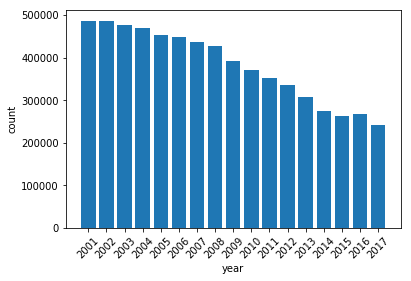

In [13]:
%matplotlib inline
_.bar()

Here we are looking at the total amount of crimes per month.

In [14]:
%%sql
SELECT hour.month_of_year, COUNT(*)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
GROUP BY hour.month_of_year
ORDER BY hour.month_of_year

12 rows affected.


month_of_year,count
1,507475
2,446449
3,536089
4,537774
5,578227
6,575722
7,605146
8,598956
9,562182
10,569547


<Container object of 12 artists>

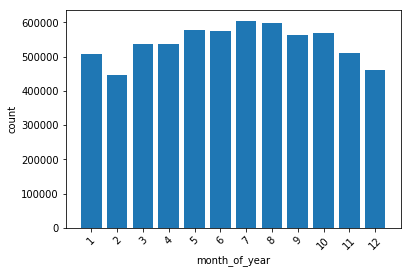

In [15]:
%matplotlib inline
_.bar()

The total amount of crime that occurs on a particular weekday. Fridays are not safe.

In [16]:
%%sql
SELECT hour.day_of_week_str, COUNT(*)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
GROUP BY hour.day_of_week, day_of_week_str 
ORDER BY hour.day_of_week

7 rows affected.


day_of_week_str,count
Sunday,876030
Monday,915620
Tuesday,930330
Wednesday,935978
Thursday,926718
Friday,977472
Saturday,926808


<Container object of 7 artists>

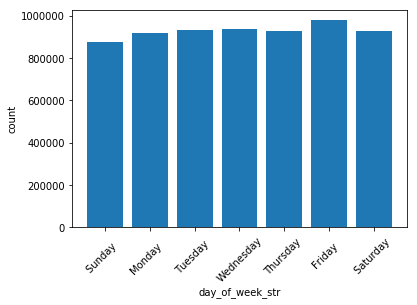

In [17]:
%matplotlib inline
_.bar()

Looking at the time of day - I would consider anything after noon quite dangerous. This is similar to the analysis of LA - anything noon and beyond were much more dangerous.

In [18]:
%%sql
SELECT hour_of_day, COUNT(*)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
GROUP BY hour_of_day
ORDER BY hour_of_day

24 rows affected.


hour_of_day,count
0,360738
1,206442
2,173180
3,139348
4,104494
5,86331
6,101940
7,146904
8,219154
9,277756


<Container object of 24 artists>

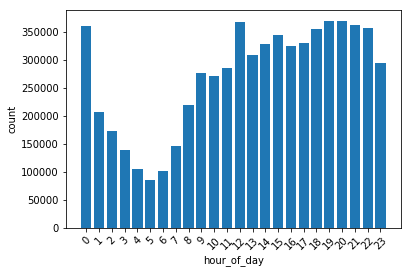

In [19]:
%matplotlib inline
_.bar()

However, our comparison to which day in the year the most crime is committed is also the same, however LA commits almost twice as much crime on New Year's than Chicago does.

In [20]:
%%sql
SELECT a.day, a.year, a.count
FROM (SELECT COUNT(*) AS count, day, hour.year
    FROM chicago_crime
    JOIN hour
    ON chicago_crime.hour_key = hour.key
    GROUP BY day, hour.year) AS a
JOIN (SELECT t.year, MAX(count) AS max_count
    FROM (SELECT COUNT(*) AS count, day, hour.year
        FROM chicago_crime
        JOIN hour
        ON chicago_crime.hour_key = hour.key
        GROUP BY day, hour.year) AS t
     GROUP BY t.year) AS b
ON a.year = b.year
AND a.count = b.max_count
ORDER BY a.year

17 rows affected.


day,year,count
2001-01-01,2001,1810
2002-01-01,2002,1853
2003-01-01,2003,2021
2004-01-01,2004,1884
2005-01-01,2005,1955
2006-01-01,2006,1897
2007-01-01,2007,1933
2008-01-01,2008,1795
2009-01-01,2009,1803
2010-01-01,2010,1404


### Type
Here we are looking at the different types of crime committed in Chicago. Where Battery was the number one crime in LA, Theft followed by Battery are the top two crimes in Chicago.

The number of battery crimes in Chicago is almost 10x more than the battery crimes in LA.

In [21]:
%%sql
SELECT type, COUNT(*)
FROM chicago_crime
GROUP BY type
ORDER BY count DESC
LIMIT 10

10 rows affected.


type,count
THEFT,1355568
BATTERY,1184458
CRIMINAL DAMAGE,744690
NARCOTICS,698473
OTHER OFFENSE,402013
ASSAULT,399086
BURGLARY,376661
MOTOR VEHICLE THEFT,304544
ROBBERY,246085
DECEPTIVE PRACTICE,242619


Here we are looking at how theft and battery has changed throughout the years.

In [22]:
%%sql
SELECT chicago_crime.type, hour.year, COUNT(type)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
GROUP BY type, hour.year
ORDER BY COUNT(type) DESC
LIMIT 10

10 rows affected.


type,year,count
THEFT,2001,99264
THEFT,2003,98875
THEFT,2002,98327
THEFT,2004,95463
BATTERY,2002,94152
BATTERY,2001,93447
THEFT,2008,88431
BATTERY,2003,88377
BATTERY,2004,87134
THEFT,2006,86240


<Container object of 10 artists>

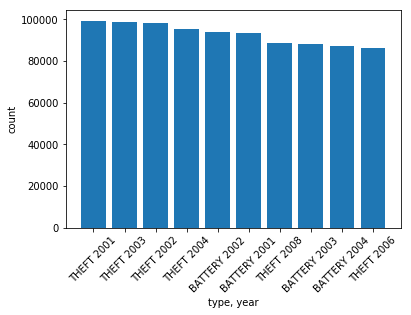

In [23]:
%matplotlib inline
_.bar()

**Focus on Battery**

Here we wanted to compare battery crimes during the week.

In [24]:
%%sql
SELECT type, day_of_week_str, COUNT(type)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
WHERE type = 'BATTERY'
GROUP BY day_of_week, day_of_week_str, type
ORDER BY day_of_week

7 rows affected.


type,day_of_week_str,count
BATTERY,Sunday,194705
BATTERY,Monday,159201
BATTERY,Tuesday,158800
BATTERY,Wednesday,159473
BATTERY,Thursday,159881
BATTERY,Friday,167118
BATTERY,Saturday,185280


<Container object of 7 artists>

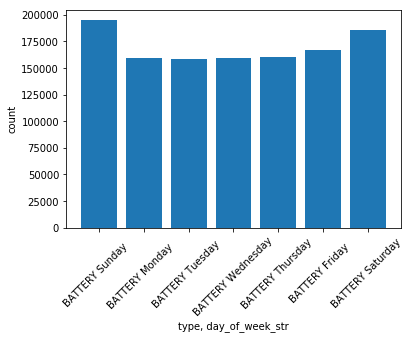

In [25]:
%matplotlib inline
_.bar()

Looking at the time battery crimes occur.

In [26]:
%%sql
SELECT type, hour_of_day, COUNT(type)
FROM chicago_crime
JOIN hour
ON chicago_crime.hour_key = hour.key
WHERE type = 'BATTERY'
GROUP BY hour_of_day, type
ORDER BY hour_of_day

24 rows affected.


type,hour_of_day,count
BATTERY,0,58892
BATTERY,1,56774
BATTERY,2,50718
BATTERY,3,41074
BATTERY,4,28743
BATTERY,5,19278
BATTERY,6,16215
BATTERY,7,20408
BATTERY,8,31125
BATTERY,9,36646


<Container object of 24 artists>

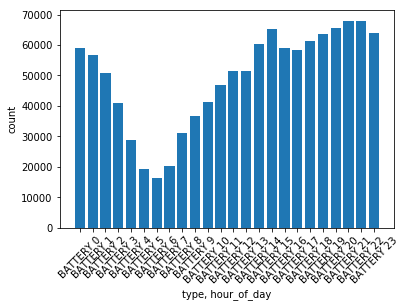

In [27]:
%matplotlib inline
_.bar()

Here we look at where battery crimes occur which is mostly Residences and Apartments, which is similar to LA.

In [28]:
%%sql
SELECT type, location, COUNT(type)
FROM chicago_crime
WHERE type = 'BATTERY'
GROUP BY location, type
ORDER BY COUNT(chicago_crime) DESC
LIMIT 10

10 rows affected.


type,location,count
BATTERY,RESIDENCE,247733
BATTERY,APARTMENT,231556
BATTERY,STREET,212282
BATTERY,SIDEWALK,176332
BATTERY,"SCHOOL, PUBLIC, BUILDING",48685
BATTERY,RESIDENCE PORCH/HALLWAY,29555
BATTERY,ALLEY,26292
BATTERY,OTHER,25862
BATTERY,PARKING LOT/GARAGE(NON.RESID.),15612
BATTERY,CHA APARTMENT,12895


**Location**

However, the majority of crimes occurred on the street followed by residences which is the same as in LA.

In [29]:
%%sql
SELECT location, COUNT(*)
FROM chicago_crime
GROUP BY location
ORDER BY count DESC
LIMIT 5

5 rows affected.


location,count
STREET,1714062
RESIDENCE,1098570
APARTMENT,664071
SIDEWALK,645248
OTHER,245749


Lastly, we wanted to check what type of crime occurred where. Theft occurred mostly on the street, whilst battery occurred mostly within a household.

In [39]:
%%sql
SELECT a.location, a.type, count
FROM (SELECT COUNT(type) AS count, location, type
    FROM chicago_crime
    GROUP BY location, type) AS a
JOIN (SELECT type, MAX(count) AS max_count
    FROM (SELECT COUNT(type) AS count, location, type
        FROM chicago_crime
        GROUP BY location, type) AS t
     GROUP BY t.type) AS b
ON a.type = b.type
AND a.count = b.max_count
ORDER BY count DESC
LIMIT 10

10 rows affected.


location,type,count
STREET,THEFT,373890
STREET,CRIMINAL DAMAGE,269179
STREET,NARCOTICS,248823
RESIDENCE,BATTERY,247733
STREET,MOTOR VEHICLE THEFT,241136
RESIDENCE,OTHER OFFENSE,186784
RESIDENCE,BURGLARY,129213
STREET,ASSAULT,83187
STREET,ROBBERY,75977
RESIDENCE,DECEPTIVE PRACTICE,66578


## Conclusion
In conclusion, although the population of LA is bigger than Chicago, the amount of crime in Chicago is much greater than LA. We would prefer to stay in LA.